**Assignment 3**

In [1]:
# Importing the datasetand required libraries

import re
import nltk
from gensim.downloader import load
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from collections import defaultdict

# Downloading the requirements
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Loading the dataset
dataset = load('text8')

dataset

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[==================================================] 100.0% 31.6/31.6MB downloaded


In [2]:
# Pre-processing the dataset
tokens = []
def preprocess(text):
  # Convert dataset to lowercase for normalization and removing stop words
  text = text.lower()
  tokens = word_tokenize(text)
  filtered_tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
  # Returning the filtered tokens
  return filtered_tokens

# Calling the preprocessing function on the sentences in dataset
for sentence in dataset:
    tokens.extend(preprocess(' '.join(sentence)))

print(tokens[:10])

['anarchism', 'originated', 'term', 'abuse', 'first', 'used', 'early', 'working', 'class', 'radicals']


In [3]:
# Building the dictionay for most common words
word_counts = Counter(tokens)
common_words = word_counts.most_common(10000)

# Dictionary of word to index for selected common words
wordIndexDict = {word: index for index, (word, _) in enumerate(common_words)}

# Dictionary of frequenies for the selected common words
wordFreqDict = {word: count for word, count in common_words}

In [4]:
len(wordFreqDict)

10000

**Implementing Continious Bag of Words:**

In [5]:
# Importing the pytorch libraries for implemneting CBOW model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [6]:
# Creating CBOW model using class from nn.Module which is the base class for all NN modules.
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()
        # Converting the word indices into dense vectors of a fixed size i.e the embedding dimension.
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        # Building the linear layer that maps from the embedding space.
        self.linear = nn.Linear(embedding_dim, vocab_size)

    # Building the forward pass of the model which takes in context indicies and returns the log probability.
    def forward(self, context_idxs):
        # Passing the context indicies through the embedding layer, taking mean and getting single embedding vector.
        embeds = self.embeddings(context_idxs).mean(dim=1)
        out = self.linear(embeds)
        # Adding the the log softmax function on the output scores to get the probabailities.
        probability = torch.log_softmax(out, dim=1)
        return probability


In [7]:
# Creating a function to generate training samples from a list of tokens.
# tokens and wordIndexDict as defined above.
# context_window: Number of words to consider on each side of the target word as its context.

def generate_training_samples(tokens, wordIndexDict, context_window):
    data_samples = []
    for i in range(context_window, len(tokens) - context_window):

        context = [tokens[i - j] for j in range(1, context_window + 1)] + \
                  [tokens[i + j] for j in range(1, context_window + 1)]
        target = tokens[i]
        if target in wordIndexDict:

            context_index = [wordIndexDict[word] for word in context if word in wordIndexDict]
            target_index = wordIndexDict[target]
            data_samples.append((context_index, target_index))
    return data_samples


In [8]:
context_window = 4  # Words on each side of the target
training_samples_cbow = generate_training_samples(tokens, wordIndexDict, context_window)
len(training_samples_cbow)

9169212

In [9]:
training_samples_cbow[:10]

[([3006, 106, 2954, 5102, 14, 51, 624, 369], 11),
 ([11, 3006, 106, 2954, 51, 624, 369], 14),
 ([14, 11, 3006, 106, 624, 369, 56], 51),
 ([51, 14, 11, 3006, 369, 56], 624),
 ([624, 51, 14, 11, 56, 37], 369),
 ([369, 624, 51, 37, 735], 56),
 ([56, 369, 735, 71], 37),
 ([37, 56, 71, 735], 735),
 ([735, 37, 735, 3449, 106, 103], 71),
 ([71, 735, 3449, 106, 103, 14], 735)]

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_cbow = CBOW(10000, 100).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer_funcion = optim.Adam(model_cbow.parameters(), lr=0.001)

In [11]:
max_context_length = max(len(context) for context, _ in training_samples_cbow)
max_context_length

from torch.utils.data import DataLoader, TensorDataset

padded_contexts = [context + [0]*(max_context_length - len(context)) for context, _ in training_samples_cbow]
contexts = torch.tensor(padded_contexts, dtype=torch.long)
targets = torch.tensor([target for _, target in training_samples_cbow], dtype=torch.long)
dataset = TensorDataset(contexts, targets)

batch_size = 1024
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [12]:
# Training
epochs = 8
for epoch in range(epochs):
    return_loss = 0
    for context, target in data_loader:
        # Prepare the inputs and targets
        context_var = context.to(device)
        target_var = target.to(device)

        # Zero the gradients
        optimizer_funcion.zero_grad()

        # Forward pass
        log_probs = model_cbow(context_var)

        # Compute the loss
        loss = loss_function(log_probs, target_var)

        # Backward pass and optimize
        loss.backward()
        optimizer_funcion.step()

        return_loss += loss.item() * context_var.size(0)

    print(f'Epoch {epoch+1}/{epochs}, Loss: {return_loss/len(training_samples_cbow)}')

Epoch 1/8, Loss: 6.996776088314521
Epoch 2/8, Loss: 6.493036264404918
Epoch 3/8, Loss: 6.361869319550223
Epoch 4/8, Loss: 6.290982208819888
Epoch 5/8, Loss: 6.243425229783172
Epoch 6/8, Loss: 6.208773475070614
Epoch 7/8, Loss: 6.182089178837671
Epoch 8/8, Loss: 6.160744622390595


In [13]:
word_embeddings_cbow = model_cbow.embeddings.weight.data
word_embeddings_cbow[:1]

tensor([[-0.3305,  0.2405, -0.2133,  0.2880,  0.2192,  0.1601,  0.2110, -0.1631,
         -0.7610, -0.0541,  0.0199,  0.1556,  0.3715,  0.6643, -0.0524, -0.5447,
         -0.0484,  0.0592, -0.0925, -0.4896,  0.1414,  0.1672,  0.0626,  0.5967,
          0.1735, -0.3523, -0.0229, -0.0329, -0.0089,  0.2111, -0.2682,  0.4100,
         -0.5455, -0.3203,  0.0489,  0.2638, -0.2217, -0.3552,  0.4710,  0.6257,
          0.0355,  0.1297,  0.1361,  0.1644, -0.0182, -0.3142,  0.1514,  0.0307,
         -0.3404, -0.1218,  0.0271,  0.0369,  0.1607, -0.1026,  0.1485,  0.1328,
         -0.1022, -0.2488,  0.0272,  0.0484, -0.2314, -0.2621,  0.1774, -0.0041,
         -0.1644,  0.2709, -0.3510,  0.0753,  0.0548,  0.1323, -0.1622, -0.0453,
         -0.2563,  0.0247,  0.1282, -0.2601, -0.2724,  0.6023,  0.0522, -0.0237,
          0.1789,  0.1908, -0.0549,  0.2075,  0.2143,  0.9083,  0.0580,  0.3219,
          0.0025,  0.4276, -0.1524, -0.6661, -0.1481, -0.2295,  0.2544,  0.1245,
         -0.1454,  0.4177,  

**Implementing Skipgram Model:**

In [22]:
# Creating SkipGram model using class from nn.Module which is the base class for all NN modules.
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGram, self).__init__()
        # Converting the word indices into dense vectors of a fixed size i.e the embedding dimension.
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        # Building the linear layer that maps from the embedding space
        self.linear = nn.Linear(embedding_dim, vocab_size)
  # Building the forward pass of the model where we have outlined how the input data flows through the model to produce the output.
    def forward(self, inputs):
        # Converting the input word indices to embeddings.
        embeds = self.embeddings(inputs)
        # Passing the embeddings through the linear layer to produce raw scores for each word in the vocabulary.
        out = self.linear(embeds)
        # Applying the log softmax function on the output scores to compute log probabilities.
        probability = torch.log_softmax(out, dim=-1)
        # Returning log probabilities.
        return probability

In [23]:
# Defining a function to generate training samples for the SkipGram model.
# tokens and wordIndexDict as created above.
# context_window: The number of words on each side of a target word to consider as its context.

def generate_training_samples_skipgram(tokens, wordIndexDict, context_window):

    data_samples = []
    for i in range(len(tokens)):
        target = tokens[i]
        if target in wordIndexDict:
            target_index = wordIndexDict[target]
            for j in range(max(0, i - context_window), min(len(tokens), i + context_window + 1)):
                if j != i:
                    context_word = tokens[j]
                    if context_word in wordIndexDict:
                        context_index = wordIndexDict[context_word]
                        data_samples.append((target_index, context_index))
    # print(data_samples)
    return data_samples


In [24]:
context_window = 2
training_samples_skipgram = generate_training_samples_skipgram(tokens, wordIndexDict, context_window)
training_samples_skipgram[:10]

[(5102, 2954),
 (5102, 106),
 (2954, 5102),
 (2954, 106),
 (2954, 3006),
 (106, 5102),
 (106, 2954),
 (106, 3006),
 (106, 11),
 (3006, 2954)]

In [25]:
model_skipgram = SkipGram(10000, 50).to(device)
loss_function = nn.NLLLoss()
optimizer_function = optim.Adam(model_skipgram.parameters(), lr=0.001)

In [27]:
from torch.utils.data import DataLoader, TensorDataset

# Building batches of dataset for GPU
targets = torch.tensor([target for target, _ in training_samples_skipgram], dtype=torch.long)
contexts = torch.tensor([context for _, context in training_samples_skipgram], dtype=torch.long)
dataset = TensorDataset(targets, contexts)

batch_size = 1026
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [28]:
# Training
epochs = 5
for epoch in range(epochs):
    return_loss = 0
    for target_idx, context_idx in data_loader:
        # Prepare inputs and targets
        target_var = target_idx.to(device)
        context_var = context_idx.to(device)

        optimizer_function.zero_grad()
        log_probs = model_skipgram(target_var)
        loss = loss_function(log_probs, context_var)
        # Backward pass and optimize
        loss.backward()
        optimizer_function.step()

        return_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {return_loss / len(training_samples_skipgram)}')


Epoch 1, Loss: 0.0070359731227716635
Epoch 2, Loss: 0.00683873307853881
Epoch 3, Loss: 0.006795459564329524
Epoch 4, Loss: 0.006773006672061777
Epoch 5, Loss: 0.0067598443517805735


In [29]:
word_embeddings_skipgram = model_skipgram.embeddings.weight.data

**Evaluation:**

In [36]:
# def cosine_similarity(embedding1, embedding2):
#     # Computing the cosine similarity
#     similarity = torch.nn.functional.cosine_similarity(embedding1, embedding2, dim=0)
#     return similarity

def cosine_similarity(embedding1, embedding2):
    # Ensure the embeddings are 1D by reshaping if necessary
    if embedding1.dim() > 1:
        embedding1 = embedding1.view(-1)
    if embedding2.dim() > 1:
        embedding2 = embedding2.view(-1)

    # Normalize the embeddings to have unit norm
    embedding1_norm = embedding1 / embedding1.norm(p=2)
    embedding2_norm = embedding2 / embedding2.norm(p=2)

    # Compute cosine similarity as the dot product of the normalized embeddings
    similarity = torch.dot(embedding1_norm, embedding2_norm)
    return similarity

def word_embedding(model, word, wordIndexDict):
    # Fetch the index of word
    word_index = torch.tensor([wordIndexDict[word]], dtype=torch.long).to(device)
    # Fetch the embedding for the particular word
    embedding = model.embeddings(word_index)
    return embedding

**CBOW Evaluation**

In [37]:
word_pairs = [('king', 'queen'), ('man', 'woman'), ('paris', 'france'), ('india', 'delhi')]
for word1, word2 in word_pairs:
    embedding1 = word_embedding(model_cbow, word1, wordIndexDict)
    embedding2 = word_embedding(model_cbow, word2, wordIndexDict)
    similarity = cosine_similarity(embedding1, embedding2)
    print(f'Cosine similarity between {word1} and {word2}: {similarity.item()}')

Cosine similarity between king and queen: 0.4182968735694885
Cosine similarity between man and woman: 0.5238789916038513
Cosine similarity between paris and france: 0.4012695550918579
Cosine similarity between india and delhi: 0.4788517355918884


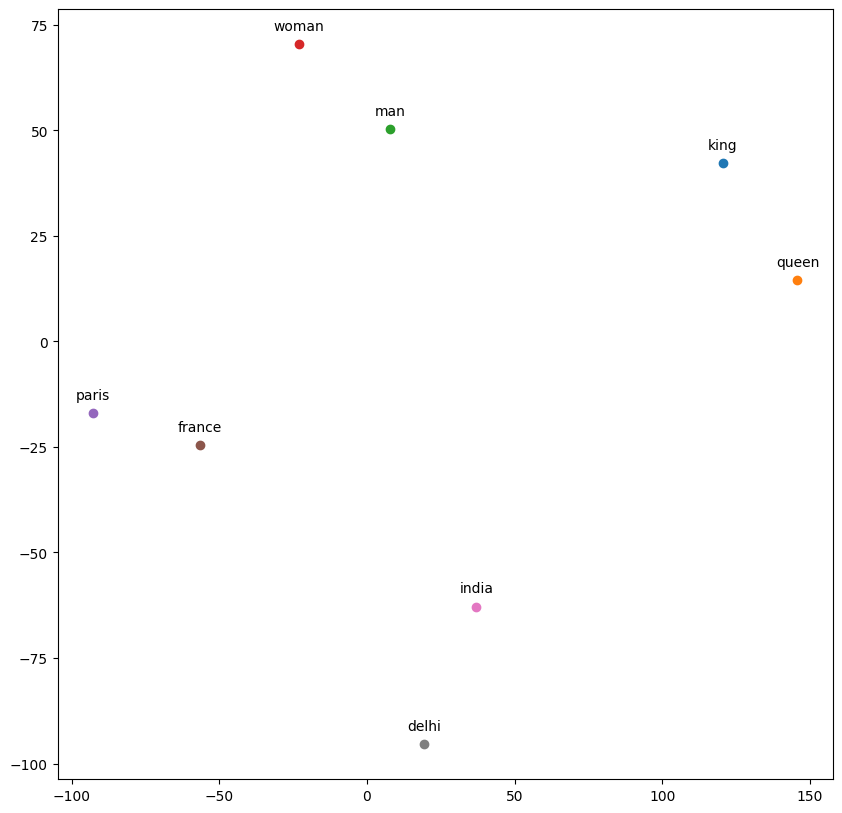

In [41]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

words_to_visualize = ['king', 'queen', 'man', 'woman', 'paris', 'france', 'india', 'delhi']

def plot(model, word_index_dict, words_to_visualize, perplexity_setting=3):
    # Fetch embeddings
    embeddings = [model.embeddings(torch.tensor([word_index_dict[word]], dtype=torch.long).to(device)).detach().cpu().numpy() for word in words_to_visualize if word in word_index_dict]
    embeddings = np.array(embeddings).reshape(len(words_to_visualize), -1)

    if len(words_to_visualize) <= perplexity_setting:
        print(f"Adjusting perplexity to {len(words_to_visualize) - 1} due to small sample size.")
        perplexity_setting = len(words_to_visualize) - 1

    # Building the TSNE model and setting perplexity as 3
    tsne = TSNE(n_components=2, perplexity=perplexity_setting)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Plotting the graph
    plt.figure(figsize=(10, 10))
    for i, word in enumerate(words_to_visualize):
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1])
        plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), textcoords="offset points", xytext=(0,10), ha='center')
    plt.show()
plot(model_cbow, wordIndexDict, words_to_visualize, perplexity_setting=3)

In [39]:
embedding_king = word_embedding(model_cbow, "king", wordIndexDict)
embedding_man = word_embedding(model_cbow, "man", wordIndexDict)
embedding_woman = word_embedding(model_cbow, "woman", wordIndexDict)
embedding_queen = word_embedding(model_cbow, "queen", wordIndexDict)

# Perform the vector arithmetic
resultant_vector = embedding_king - embedding_man + embedding_woman

# Calculate the cosine similarity with "queen"
similarity_with_queen = cosine_similarity(resultant_vector, embedding_queen)

print(f'Cosine similarity between the resultant vector and "queen": {similarity_with_queen.item()}')

Cosine similarity between the resultant vector and "queen": 0.40971651673316956


**Skipgram Evaluation**

In [40]:
word_pairs = [('king', 'queen'), ('man', 'woman'), ('paris', 'france'), ('india', 'delhi')]
for word1, word2 in word_pairs:
    embedding1 = word_embedding(model_skipgram, word1, wordIndexDict)
    embedding2 = word_embedding(model_skipgram, word2, wordIndexDict)
    similarity = cosine_similarity(embedding1, embedding2)
    print(f'Cosine similarity between {word1} and {word2}: {similarity.item()}')

Cosine similarity between king and queen: 0.5187264680862427
Cosine similarity between man and woman: 0.6885019540786743
Cosine similarity between paris and france: 0.6117424964904785
Cosine similarity between india and delhi: 0.5685548782348633


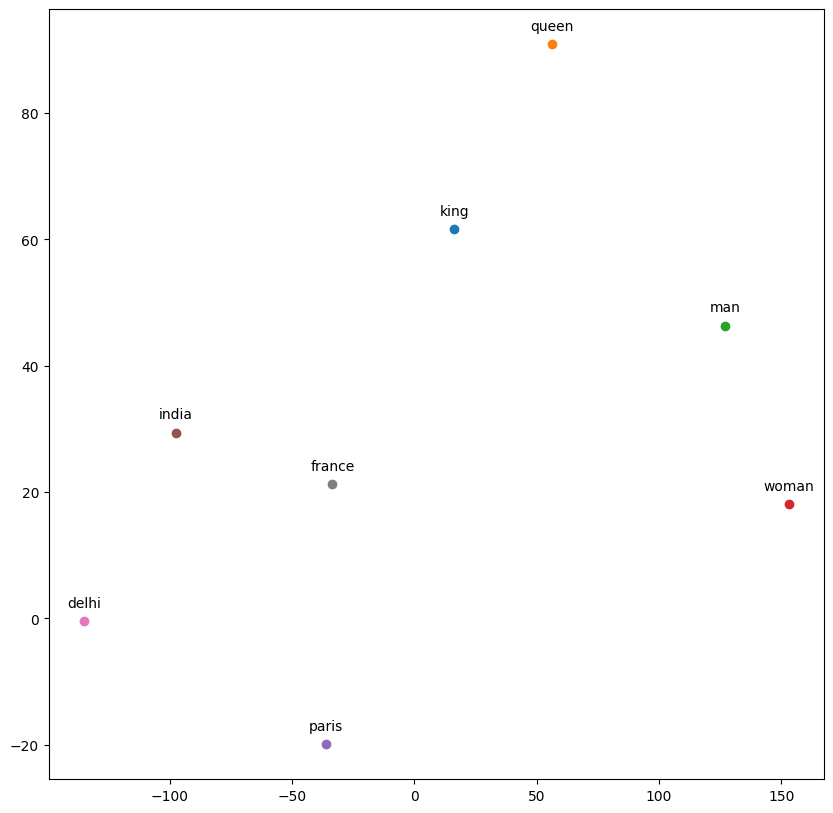

In [42]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

words_to_visualize = ['king', 'queen', 'man', 'woman', 'paris', 'india', 'delhi', 'france']

def plot(model, word_index_dict, words_to_visualize, perplexity_setting=3):
    # Fetching embeddings
    embeddings = [model.embeddings(torch.tensor([word_index_dict[word]], dtype=torch.long).to(device)).detach().cpu().numpy() for word in words_to_visualize if word in word_index_dict]
    embeddings = np.array(embeddings).reshape(len(words_to_visualize), -1)

    if len(words_to_visualize) <= perplexity_setting:
        print(f"Adjusting perplexity to {len(words_to_visualize) - 1} due to small sample size.")
        perplexity_setting = len(words_to_visualize) - 1

    # Building the TSNE model and setting perplexity as 3
    tsne = TSNE(n_components=2, perplexity=perplexity_setting)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Plotting the figure
    plt.figure(figsize=(10, 10))
    for i, word in enumerate(words_to_visualize):
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1])
        plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), textcoords="offset points", xytext=(0,10), ha='center')
    plt.show()
plot(model_skipgram, wordIndexDict, words_to_visualize, perplexity_setting=3)

**Report**

**Introduction to word embeddings, Skipgram, and CBOW:**

Word embeddings are a class of techniques where individual words are represented as real-valued vectors in a predefined vector space. Each word is mapped to a vector in a form that it can be used as human language context while training Machine Learning Models. Even though there are simpler methods such as count vectorizer and TFIDF vectorizer however they do not help preserves context.  This approach enables machines to understand words in a more human-like manner and the two main methods for generating word embeddings are Skip-gram and Continuous Bag of Words (CBOW).

**Skipgram model:**
The Skip-gram model is designed to predict the context for a given target word. For a specific word in a sentence, the model tries to predict the surrounding words within a certain range defined by a window size.

Skipgram works well with a small amount of the training data, represents well even rare words or phrases.

**Continious bag of words model:**
In contrast to the Skip-gram model, the CBOW model predicts a target word based on its context. Instead of using a single word to predict its context, CBOW takes multiple context words as input and tries to predict the word that is most likely to appear in the center of those context words.

CBOW several times faster to train than the skip-gram, slightly better accuracy for the frequent words.

**Architecture of the models:**

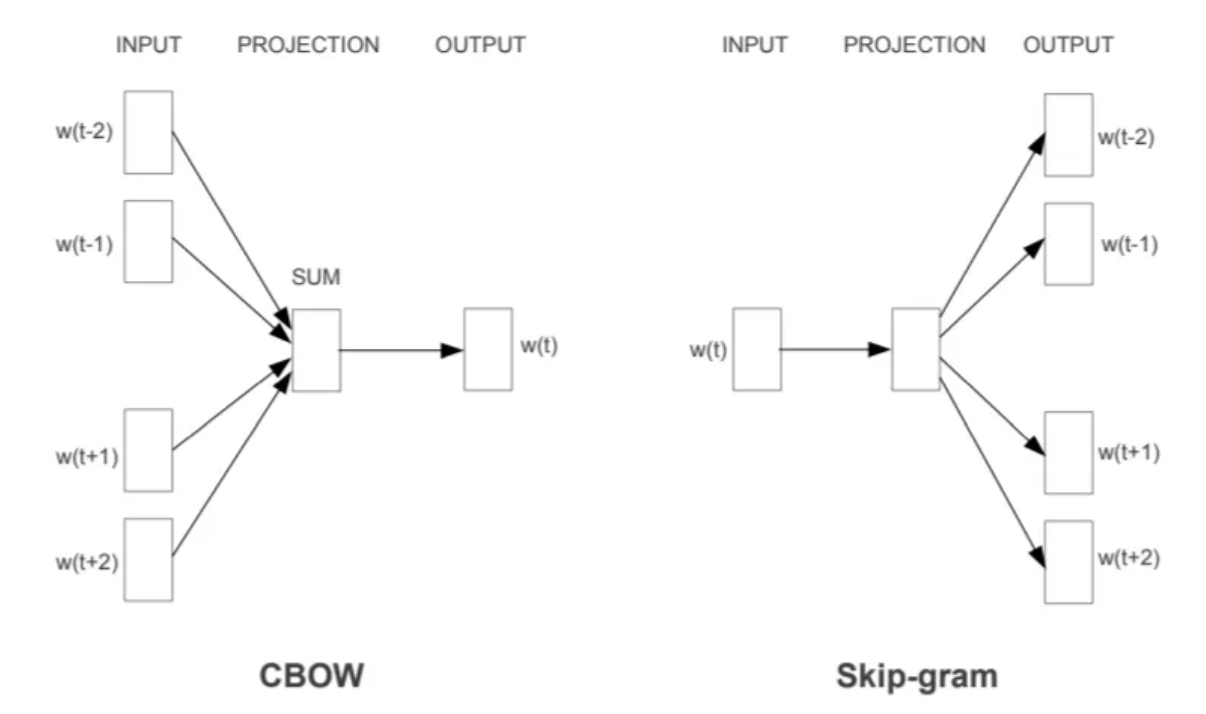


Both the above architectures to learn the underlying word representations for each word by using neural networks.

The Continuous Bag of Words (CBOW) and Skip-Gram models are two architectures within the Word2Vec family designed to generate word embeddings, which are dense vector representations of words capturing their semantic meanings.

In the CBOW architecture, the model predicts a target word based on its surrounding context words. It takes multiple context words as input and outputs the probability distribution of the target word.

Conversely, the Skip-Gram model inverts this approach by taking a single target word as input and predicting its surrounding context words.

**Dataset and pre-processing steps:**

The dataset is the text8 dataset which is a cleaned version of the first 100MB of the English Wikipedia dump.

For preprocessing steps, the text is normalized first by lowercasing to ensure uniformity, followed by tokenization to break down sentences into individual words or tokens. This preprocessing step involves filtering process where we removes non-alphabetic tokens and stopwords.

After that we build vocab with the entire dataset and fetch the 10,000 most common words. Last step is to build the two key dictionaries: one mapping these common words to unique indices and another mapping words to their frequencies.

**Results from the evaluation step:**

CBOW Results:
After multiple changes in the hyperparameters, the model was trained for 8 epochs and we can observe that loss reduces after each epoch, indicating the model's improving ability to predict target words from their context.

The measured cosine similarities between pairs of related words (e.g., king and queen, man and woman) demonstrate a moderate level of semantic understanding, with values such as 0.418 for 'king' and 'queen' and 0.524 for 'man' and 'woman'.

From the graph, we also observe that the model is able to understand the words given upto an extent and is able to cluster them into similar categories when TSNE is used.

Skipgram Results:

Skipgram models depicts a slightly superior performance even though it was trained for lower epochs. The similarity between 'man' and 'woman' reached 0.688, and 'paris' and 'france' scored 0.612, indicating a deeper understanding of these relationships compared to CBOW.

**Challenges faced during implementation and potential improvements:**

The most significant challenge encountered was the training process. Training the Skip-Gram model without access to a GPU node took several hours, which made me decide to utilize an available GPU node to expedite the process. I also decided to take a batch processing approach in order to expediate the training process.

Another issue encountered during implementation was determining the optimal hyperparameters. Due to the extended training times, experimenting with different hyperparameters and comparing results became even more challenging.

Lastly, handling out-of-vocabulary (OOV) words presented difficulties. OOV words are those that do not appear in the training dataset and, therefore, the model has not learned to represent or predict.

**Insights and potential applications of the implemented models:**


Implementing both the Skip-Gram and Continuous Bag of Words (CBOW) models offers insights into the construction and application of word embeddings in natural language processing. These models underscore the importance of context in understanding word meanings, with Skip-Gram excelling in capturing fine-grained relationships by predicting surrounding context words from a target word and CBOW efficiently predicting a target word from its context.

There are various applications of these models in the domain of NLP such as:

**Semantic Analysis:** The embeddings generated by Skip-Gram and CBOW can be used for semantic analysis tasks, such as sentiment analysis, where the nuanced meaning of words in context is crucial for accurately determining the sentiment of text.

**Text Summarization:** Embeddings can improve the performance of text summarization algorithms by helping them to identify the most relevant and important information in a text based on the semantic significance of words.